In [1]:
### IGNORE: unless you have a gpu and receive the error noted

# source: https://www.tensorflow.org/guide/gpu 
# code to avoid "Attempting to perform BLAS operation using StreamExecutor without BLAS support" error 

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Memory growth must be set before GPUs have been initialized
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


### Sequence model

### Create data generators 

In [2]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5001 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [3]:
for train, target in train_ds:
    print(train[0].numpy())
    print("\n")
    print(target[0].numpy())
    break

b"First of all I am a butch, straight white male. But even with that handicap I love this movie. It's about real people. A real time and place. And of course New York City in the 80's. I had many gay friends growing up in New York in the eighties and the one thing about them i always admired was their courage to live their lives the way they wanted to live them. No matter what the consequences. That's courageous. You have to admire that. This is a great film, watch it and take in what it was like to be a flamboyant African American or Hispanic Gay man in the New York of the eighties. It's real life. Bottom line it's real life."


1


#### Approach 1: one-hot encoding

In [27]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

max_tokens = 20000
max_length = 100

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [28]:
for i, word in enumerate(text_vectorization.get_vocabulary()):
    if not word:
        word = "''"
    print(f"{word} = {i}")
    if i==10:
        break

'' = 0
[UNK] = 1
the = 2
a = 3
and = 4
of = 5
to = 6
is = 7
in = 8
it = 9
i = 10


In [29]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y))

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y))

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y))

In [30]:
for reviews, targets in int_train_ds:
    print("reviews.shape:", reviews.shape)
    print("\nreviews.dtype:", reviews.dtype)
    print("\ntargets.shape:", targets.shape)
    print("\ntargets.dtype:", targets.dtype)
    print("\nreviews[0]:", reviews[0])
    print("\ntargets[0]:", targets[0])
    break

reviews.shape: (32, 100)

reviews.dtype: <dtype: 'int64'>

targets.shape: (32,)

targets.dtype: <dtype: 'int32'>

reviews[0]: tf.Tensor(
[   49    69    29   131    43     3    20    12    44    29     5     2
     1    87 19184     4  1935    87 14352    10   480   131     1    76
   131  3260  1727     8     2   474     5     2   458     4     2   114
  2895   536   230  3837     4  5876    67     8    65 10233    11     7
    34  1652    43     3 10419   503  6918   905  7890     4  1204  1416
   536    17    25  3012     4  2142   418 16735    10   445     9   295
  1432     4  1664  5423    67    80  1727  2953  9382    14    52   744
  4242     4  8445     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int64)

targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [31]:
raw_text_data = ([
    ["That was an excellent movie, I loved it."],
])

x = text_vectorization(raw_text_data)

In [32]:
x

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 12,  14,  34, 312,  18,  10, 445,   9,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)>

In [33]:
tf.one_hot(x, depth=max_tokens)

<tf.Tensor: shape=(1, 100, 20000), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [34]:
import tensorflow as tf

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_3 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               5128448   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [35]:
callbacks = keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                             save_best_only=True)

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=[callbacks])

Epoch 1/10
625/625 [==============================] - 48s 59ms/step - loss: 0.5022 - accuracy: 0.7511 - val_loss: 0.3829 - val_accuracy: 0.8296
Epoch 2/10
625/625 [==============================] - 36s 57ms/step - loss: 0.3424 - accuracy: 0.8551 - val_loss: 0.3959 - val_accuracy: 0.8314
Epoch 3/10
625/625 [==============================] - 36s 57ms/step - loss: 0.2839 - accuracy: 0.8862 - val_loss: 0.4119 - val_accuracy: 0.8188
Epoch 4/10
625/625 [==============================] - 36s 57ms/step - loss: 0.2475 - accuracy: 0.9031 - val_loss: 0.4161 - val_accuracy: 0.8374
Epoch 5/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2122 - accuracy: 0.9183 - val_loss: 0.3841 - val_accuracy: 0.8396
Epoch 6/10
625/625 [==============================] - 36s 58ms/step - loss: 0.1798 - accuracy: 0.9337 - val_loss: 0.4566 - val_accuracy: 0.8330
Epoch 7/10
625/625 [==============================] - 36s 57ms/step - loss: 0.1494 - accuracy: 0.9449 - val_loss: 0.4618 - val_accuracy:

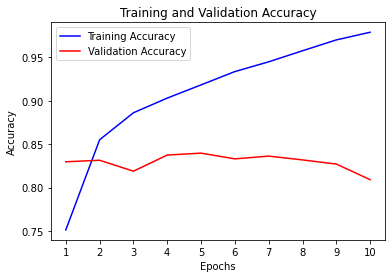

In [38]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values)+1)

plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 27s 34ms/step - loss: 0.4071 - accuracy: 0.8163
Test acc: 0.816
